In [93]:
import array as arr
import csv
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [94]:
def step(t, dt):
    t = t + dt
    return t

In [95]:
def drawRect(q_curr, width_v, length_v):
    
    xl  = q_curr[0] + width_v / 2  # left x coordinate
    xr  = q_curr[0] - width_v / 2  # right x coordinate
    
    yf  = q_curr[1] - length_v / 2 # front
    yb  = q_curr[1] + length_v / 2 # back
    
#     print("x-loc rectangle,", x, "y-loc rectangle,", y)
    
    verts = []

    xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
    ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
    z_axis = [0, 0, 0, 0, 0]

    verts = [list(zip(xs, ys, z_axis))]
       
    poly = Poly3DCollection(verts, facecolors="blue", closed = False)
    ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [96]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [97]:
class camera(object):
    def __init__(self):      
        
        #################### CLASS VARIABLES ####################
        self.width = 2         # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index

        ######################## MODULES ########################
        self.indexVisFruit = queue.SimpleQueue()
        
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2
        view_max = q_curr + self.width / 2

        # fix end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row

        i = self.i_lastFruit # might need to change this if fruits move around

        # look through sorted (around y-axis) array to find all "visible fruit"
        while(True):
            if sortedFruit[1,i] > view_min and sortedFruit[1,i] < view_max:
                self.indexVisFruit.put(i)
                
            elif sortedFruit[1,i] > view_max:
                break
            i = i + 1
            
        self.i_lastFruit = i


In [98]:
def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
    i_goal = indexVisFruit.get()
#     print(i_goal)

In [99]:
class arm(object):
    def __init__(self, q):
              
        #################### CLASS VARIABLES ####################
        self.q_a = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        self.length_f  = 0.5     # how far can it go into trees, in m
        self.width_f   = 2.5     # size of enclosing frame, width in m
        self.height_f  = 2.      # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f = np.array([5.5,9.,4.])  # frame's location in the world's frame of reference
        self.x_edges_f = np.array([0.,0.])
        self.y_edges_f = np.array([0.,0.])
        self.z_edges_f = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max     = 1.
        self.a_max     = 10. 
        self.d_max     = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free      = 1       # start ready to be given a goal 
        self.goal      = np.array([0.,0.,0.])
        self.goal_r    = np.array([0,0,0]) # has the goal been rached at each axis
        self.x_move    = 0       # allows the x-dir to start moving
        
        # following the trapezoidal trajectory
        self.t         = 0.      # time at which the arm will begin moving to the goal
        self.tx        = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, q_curr, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # q_curr is the arm's location within the world frame
        # v_v is the vehicle's velocity
        
        print("has goal been reached, x, y, z", self.goal_r)

        goal_time   = t - self.t  # time since the y-z self timer was started
        goal_time_x = t - self.tx # time since the x self timer was started => not updating correctly
    
        # move towards the goal
        self.moveFrame(v_v, dt)    # start with the frame
        
        # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
        # in the y-axis:
        self.calcYVel(goal_time, v_v)
        # in the z-axis:  
        self.calcZVel(goal_time) # not affected by the vehicle's velocity

        # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
        if self.goal_r[1] == 1 and self.goal_r[2] == 1:
            # check that it's the first time this has been reached since a new goal was given
            if self.tx == 0.:        
                self.tx     = t      # start of the new timer for x
                goal_time_x = 0.     # restart the timer for x
                self.x_move = 1      # allow movement in the x-direction

        if self.x_move == 1: 
            self.calcXVel(goal_time_x, v_v)
            
            
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt
        
        print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))
        print("")

        # if goal has been reached, set free to one so a new goal can be given
        if self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1:
            self.free   = 1
            self.tx     = 0.
            self.x_move = 0
            # restart the goal reached values for all axis when new goal is given
            self.goal_r[0] = 0
            self.goal_r[1] = 0
            self.goal_r[2] = 0
 
            self.calcError()
            print("")
            print("Error in X:",self.error[0], "Error in Y:", self.error[1], "error in Z:", self.error[2])
            print("")
        
        return self.q_a
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        # move the center point as the vehicle moves
        self.q_f[0] = self.q_f[0] + v_v[0]*dt
        self.q_f[1] = self.q_f[1] + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = self.x_edges_f[0] + v_v[0]*dt
        self.x_edges_f[1] = self.x_edges_f[1] + v_v[0]*dt
        
        self.y_edges_f[0] = self.x_edges_f[0] + v_v[1]*dt
        self.y_edges_f[1] = self.x_edges_f[1] + v_v[1]*dt
        
#         # draw the frame
#         self.drawFrame()


    def drawFrame(self):
        xb  = self.x_edges_f[0]  # back x coordinate
        
        yf  = self.y_edges_f[0]  # front y coordinate
        yb  = self.y_edges_f[1]  # back y coordinate

        zt  = self.z_edges_f[0]  # top z coordinate
        zb  = self.z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xb, xb, xb, xb, xb]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
    
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        elif goal_time_x <= self.x.Ta + self.x.Tv + (2*self.x.Td):         # need to make it retract
            self.v_a[0] = self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv + self.x.Td)) - v_v[0]
            
        elif goal_time_x <= self.x.Ta + (2*self.x.Tv) + (2*self.x.Td):
            self.v_a[0] = -self.x.vr - v_v[0]
            
        elif goal_time_x <= (2*self.x.Ta) + (2*self.x.Tv) + (2*self.x.Td):
            self.v_a[0] = -self.x.vr - self.x.ar*(goal_time_x - (self.x.Ta + (2*self.x.Tv) + (2*self.x.Td))) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [100]:
# open CSV file and populate fruits on grid
x_fr = []
y_fr = []
z_fr = []

# with open('Applestotheleft.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for row in spamreader:
#         x_fr.append(float(row[0]))
#         y_fr.append(float(row[1]))
#         z_fr.append(float(row[2]))
        
with open('Applestotheright.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        x_fr.append(float(row[0]))
        y_fr.append(float(row[1]))
        z_fr.append(float(row[2]))

x_fruit = np.array(x_fr)
y_fruit = np.array(y_fr)
z_fruit = np.array(z_fr)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x_fr, y_fr, z_fruit])

rowIndex = 1 # sort based on y-axis
sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [101]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 12.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

In [102]:
# init vehicle
width_v = 1     # vehicle width
length_v = 5    # vehicle length
num_arms = 1    # set number of arms on robot
q_y  = []     
q_x  = []
q_v = np.array([5.5,9.]) # starting location
v_v = np.array([0.,0.1]) # in m, constant velocity
# v_v = np.array([0.,0.]) # in m, constant velocity

qv0 = []
qv1 = []

In [103]:
# init camera
picture = camera()

In [104]:
# init scheduler
goal = np.zeros(3) # does ithis go here?

In [105]:
# init arms
q_a = np.array([q_v[0],q_v[1],4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms

a1 = arm(q_a) # initialize the arm

# for plotting
error_y = []
error_z = []

qa0 = []
qa1 = []
qa2 = []

In [106]:
##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    q_x.append(float(q_v[0]))  # to plot it out later
    q_y.append(float(q_v[1]))
    
    
    # env.obs / camera... FLASH!
    picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a FIFO queue of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    
    # schedule
    # check if there are any arms that are free 
    for arm_free in range(0,num_arms):
        if a1.free == 1:
            # make sure there are available goals left in the queue
            if not picture.indexVisFruit.empty():
                i_f = picture.indexVisFruit.get()  # get a new goal
        #         print(picture.indexVisFruit.qsize()) # check the size of the queue
                
                # check to which arm the goal should go
                                
                # give the goal 
                a1.setGoal(sortedFruit[:,i_f], t_new)
#                 a1.goal = sortedFruit[:,i_f]
                # need to add a check to see if the machine can still get it?
            else:
                a1.goal = ([0,0,0]) # clear the goal section I guess

    
    # have each arm take a step
    for arm2step in range(0,num_arms):
        q_a = a1.armStep(v_v, q_a, dt, t_new)
#         print("arm location:", q_a)


#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break

    # list of error btw location and goal coordinates
    error_y.append(float(a1.error[1]))
    error_z.append(float(a1.error[2]))
    
    # plotting data
    qa0.append(float(a1.q_a[0]))
    qa1.append(float(a1.q_a[1]))
    qa2.append(float(a1.q_a[2]))
    
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
               
    runs+=1
    

        
        

start, end, start velocity: 5.5 8.1181654718 0
start, end, start velocity: 9.0 8.019408676 0
start, end, start velocity: 4.0 4.7879724914 0
X-axis, Ta: 0.1 Tv: 2.5181654717999993 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.8805913240000006 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.6879724913999997 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: 1.0 10.0 10.0
 
has goal been reached, x, y, z [0 0 0]
goal:         8.1182  8.0194  4.7880
arm location: 5.5000  9.0000  4.0000

has goal been reached, x, y, z [0 0 0]
goal:         8.1182  8.0194  4.7880
arm location: 5.5000  8.9990  4.0010

has goal been reached, x, y, z [0 0 0]
goal:         8.1182  8.0194  4.7880
arm location: 5.5000  8.9970  4.0030

has goal been reached, x, y, z [0 0 0]
goal:         8.1182  8.0194  4.7880
arm location: 5.5000  8.9940  4.0060

has goal been reached, x, y, z [0 0 0]
goal:         8.1182  8.0194  4.7880
arm location: 5.5000  8.9900  4.0100

has goal been reached, x, y, z [0 0 0]
goal

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.7850  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.7950  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.8050  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.8150  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.8250  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.8350  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.8450  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 6.8550  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location

goal:         8.1182  8.0194  4.7880
arm location: 7.1550  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.1450  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.1350  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.1250  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.1150  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.1050  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.0950  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.0850  8.0194  4.7880

has goal been reached, x, y, z [0 1 1]
goal:         8.1182  8.0194  4.7880
arm location: 7.0750  8.0194  4.7880

has goal been

goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.1430

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.1330

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.1230

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.1130

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.1030

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.0930

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.0830

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.0730

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  4.0630

has goal been

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3930

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3830

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3730

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3630

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3530

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3430

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3330

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location: 5.4963  8.0225  1.3230

has goal been reached, x, y, z [0 1 0]
goal:         9.7717  8.0225  1.0307
arm location

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.2513  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.2613  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.2713  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.2813  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.2913  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.3013  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.3113  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.3213  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location

arm location: 9.6413  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.6513  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.6613  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.6713  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.6813  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.6913  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.7013  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.7113  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 9.7213  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:      

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7813  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7713  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7613  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7513  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7413  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7313  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7213  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location: 7.7113  8.0225  1.0307

has goal been reached, x, y, z [0 1 1]
goal:         9.7717  8.0225  1.0307
arm location

has goal been reached, x, y, z [0 0 0]
goal:         9.9202  8.0417  1.0667
arm location: 5.4871  8.0416  1.0637

has goal been reached, x, y, z [0 1 0]
goal:         9.9202  8.0417  1.0667
arm location: 5.4871  8.0416  1.0657

has goal been reached, x, y, z [0 1 0]
goal:         9.9202  8.0417  1.0667
arm location: 5.4871  8.0416  1.0667

has goal been reached, x, y, z [0 1 0]
goal:         9.9202  8.0417  1.0667
arm location: 5.4871  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 5.4881  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 5.4901  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 5.4931  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 5.4971  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.7421  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.7521  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.7621  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.7721  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.7821  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.7921  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.8021  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.8121  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location


has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.3421  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.3321  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.3221  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.3121  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.3021  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.2921  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.2821  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 9.2721  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm locatio

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.0421  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.0321  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.0221  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.0121  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 7.0021  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 6.9921  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 6.9821  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location: 6.9721  8.0416  1.0667

has goal been reached, x, y, z [0 1 1]
goal:         9.9202  8.0417  1.0667
arm location

goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.7717

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.7817

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.7917

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.8017

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.8117

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.8217

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.8317

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.8417

has goal been reached, x, y, z [0 1 0]
goal:         8.5432  8.0707  4.8552
arm location: 5.4933  8.0706  1.8517

has goal been

num runs 3001


<IPython.core.display.Javascript object>


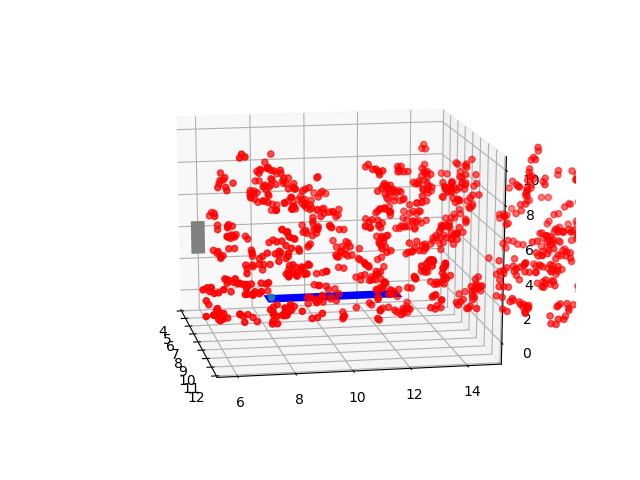

KeyboardInterrupt: 

In [107]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(0,runs):
    if run % 20 == 0:
        ax.clear()
        
        ax.scatter(sortedFruit[0,:], sortedFruit[1,:], sortedFruit[2,:], c='r', marker='o') 
            
        q_vehicle = [qv0[run], qv1[run]]
        drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        a1.drawFrame()
        ax.scatter(qa0[run], qa1[run], qa2[run], 'b', label='arm1')

        ax.set_xlim(4, 12)
        ax.set_ylim(q_v[0], end_row+3)

        fig.canvas.draw()
        time.sleep(0.5)
       
    
    
fig.show()

